# Search Parameters

In [33]:
seed = 70 # seed for NMF topic model
num_topics = 12
query = 'title-abs-key("silk" OR "collagen" AND "biomaterial" AND "molecular dynamics")'
# query = 'title-abs-key("silk" AND "biomaterial" AND "molecular dynamics") AND AUTH("kaplan")'
# query = 'FIRSTAUTH("yeo j. j.")'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("neurotransmitter" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine" OR "GABA"))'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "anxiety" OR "eating disorder"))'
# query = 'title-abs-key("neurotransmitter" AND ("GABA" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine") AND ("mental health" OR "mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "eating disorder" OR "anxiety"))'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("mental health" OR "mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "eating disorder" OR "anxiety") AND ("GABA" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine"))'
# query = 'title-abs-key("deep learning" AND ("autonomous" OR "self-driving" OR "robotic" OR "driverless" AND ("car" OR "cars" OR "driving")))'
# query = 'title-abs-key("autonomous driving" OR "self-driving car" OR "robotic car" OR "driverless car")'

labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6 # seed for t-SNE visualization
vis_angle = 135 # rotation angle for visualization

# Import Modules

In [34]:
import random
import gensim
import pybliometrics.scopus as scopus
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets

from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')

import logging
logging.getLogger().setLevel(logging.INFO)

# some python 3 trickery
import sys
if sys.version_info[0] >= 3:
    unicode = str

In [35]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

# Perform Query

In [36]:
eids = scopus.ScopusSearch(query).get_eids()
random.seed(0)
random.shuffle(eids)

bar = widgets.IntProgress(
    min=0, 
    max=len(eids), 
    description='Loading')
display(bar)

print('query: {} ({} results)'.format(query, len(eids)))

papers = []
for eid in eids:
    papers.append(scopus.AbstractRetrieval(eid, view='FULL'))
    bar.value += 1
    bar.description = str(bar.value)

print('scopus returned {} results'.format(len(papers)))

# Filter on article type
# ar = article, cp = conference proceeding, re = review
print(set([p.srctype for p in papers]))

# Filter on citation type
#papers = [p for p in papers if p.citationType in ('ar', 'cp', 're') or p.citationType is None]

# Filter on date
#papers = [p for p in papers if int(p.coverDate[:4]) <= 2018]

print('{} papers remaining'.format(len(papers)))

IntProgress(value=0, description='Loading', max=110)

query: title-abs-key("silk" OR "collagen" AND "biomaterial" AND "molecular dynamics") (110 results)
scopus returned 110 results
{'k', 'p', 'j'}
110 papers remaining


In [37]:
texts = []
for p in papers:
    text = (p.title or '') + ' ' + (p.abstract or '')
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

# Analysis

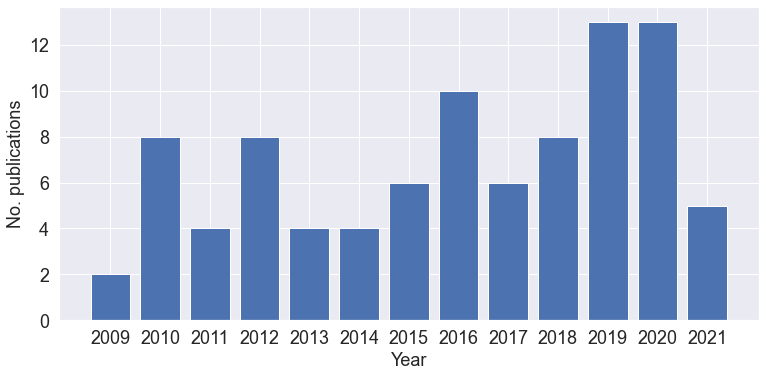

In [38]:
# Publications per year
year_count = defaultdict(int)

for p in papers:
    year_count[int(p.coverDate[:4])] += 1
       
years = range(2009, 2022)

prepare_fig(1.8, 1.8)
plt.ylabel("No. publications",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.bar(
    years,
    [year_count[y] for y in years])
plt.xticks(years);
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('years_ad.pdf')

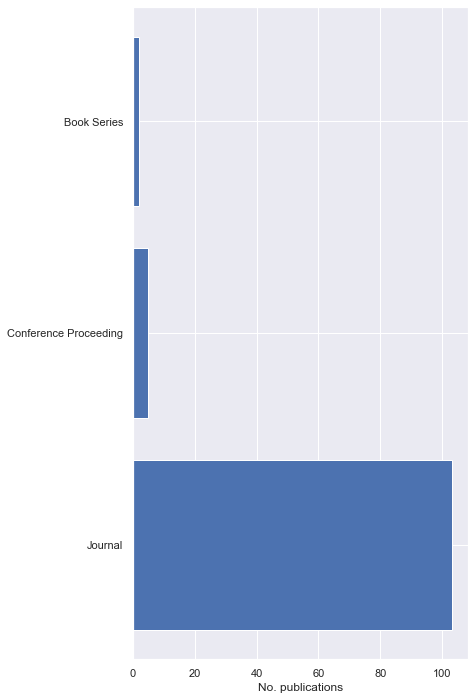

In [39]:
# Publications per aggregation type
def plot_statistic(fun):
    count = defaultdict(int)

    for p in papers:
        for key in fun(p):
            if key:
                count[unicode(key)] += 1

    top_keys = top_k(count, 50)

    prepare_fig(1, 4)
    plt.xlabel("No. publications")
    plt.barh(
        range(len(top_keys)),
        [count[a] for a in top_keys])
    plt.yticks(
        range(len(top_keys)), 
        [key[:50] for key in top_keys])
    plt.show()

plot_statistic(lambda p: [p.aggregationType])

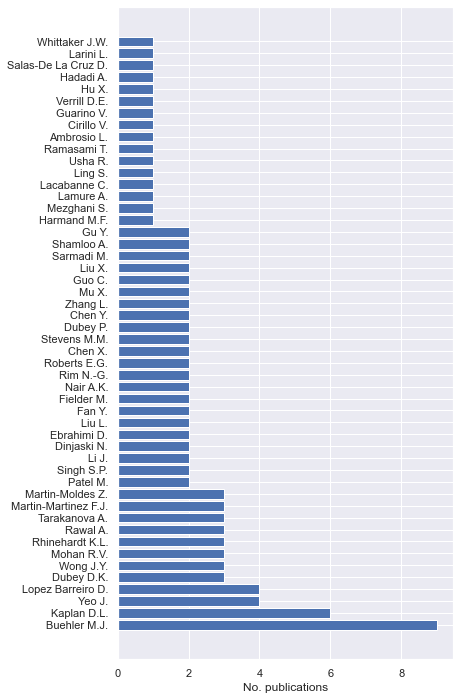

In [40]:
# Publications per author
plot_statistic(lambda p: set(a.indexed_name for a in p.authors or []))

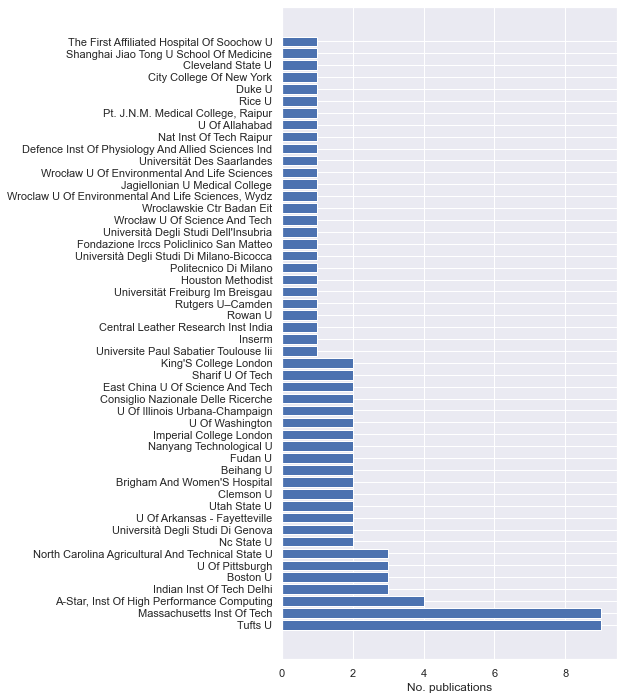

In [41]:
# Publications per institute
def clean_affiliation(name):
    name = unicode(name).title()
    pairs = [
        ['University', 'U'],
        ['Universitat', 'U'],
        ['Laboratories', 'Lab'],
        ['Laboratory', 'Lab'],
        ['National', 'Nat'],
        ['Corporation', 'Corp'],
        ['Technology', 'Tech'],
        ['Institute', 'Inst'],
    ]
    
    for needle, replacement in pairs:
        name = name.replace(needle, replacement)
    return name

plot_statistic(lambda p: set(clean_affiliation(a.name) for a in p.affiliation or []))

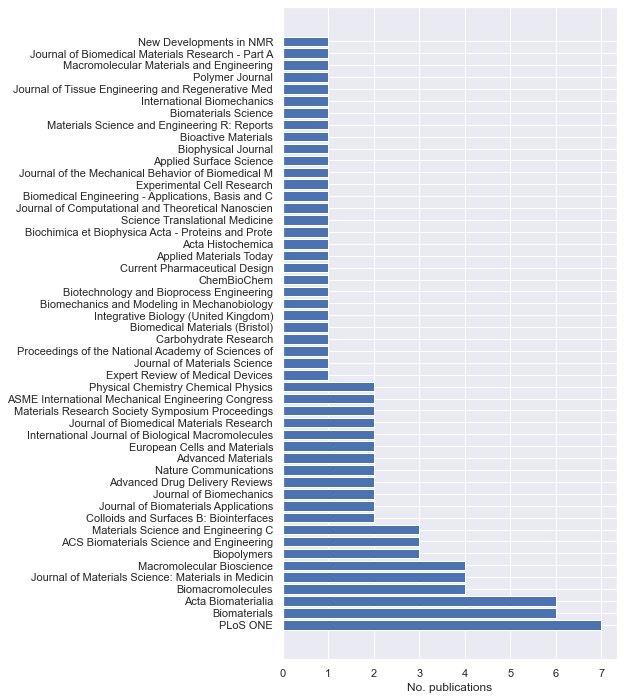

In [42]:
# Publications per publication source, conference/journal (TODO: cleaning!)
plot_statistic(lambda p: [p.publicationName])

# Topic Modeling
## Preprocessing

In [43]:
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 152 stopwords
loaded 42 bigrams
loaded 2 stem rules


In [44]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,1325,Yes
1,of,1146,Yes
2,and,902,Yes
3,in,550,Yes
4,to,514,Yes
5,a,436,
6,collagen,263,
7,for,259,Yes
8,with,228,Yes
9,that,210,Yes


In [45]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(molecular, dynamics)",51,
1,"(mechanical, properties)",36,
2,"(extracellular, matrix)",31,
3,"(tissue, engineering)",25,
4,"(spider, silk)",23,
5,"(self, assembly)",19,
6,"(dynamics, simulations)",19,
7,"(mesenchymal, stem)",17,
8,"(b, mori)",16,
9,"(type, i)",16,


In [46]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [47]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [48]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

INFO:root:stemming reduced 3687 to 2618 tokens


,Original,Stem,Unstem,Count
0,collagen,collagen,collagen,263
1,molecular,molecular,molecular,127
2,silk,silk,silk,116
3,cell,cell,cell,106
4,properties,properti,properties,106
5,protein,protein,protein,99
6,biomaterials,biomateri,biomaterials,96
7,tissue,tissu,tissue,88
8,mechanical,mechan,mechanical,80
9,proteins,protein,protein,74


## Create Dictionary

In [49]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = [papers[i] for i in indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 105 (removed 5)


In [50]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(2613 unique tokens: ['accompanied', 'adapting', 'adhered', 'adjusts', 'adsorbed']...) from 105 documents (total 14864 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary(2613 unique tokens: ['accompanied', 'adapting', 'adhered', 'adjusts', 'adsorbed']...) from 105 documents (total 14864 corpus positions)", 'datetime': '2021-06-11T08:57:39.569692', 'gensim': '4.0.1', 'python': '3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:59:12) \n[Clang 11.0.1 ]', 'platform': 'Darwin-19.6.0-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 9 tokens: [('biomaterials', 86), ('structure', 59), ('study', 58), ('collagen', 63), ('dynamics', 56), ('properties', 53), ('mechanical', 54), ('molecular', 64), ('tissue', 53)]...
INFO:gensim.corpora.dictionary:keeping 2604 tokens which were in no less

papers: 105
dictionary size: 516


## Topic Modeling

In [51]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq
        

In [52]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [53]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


violation: 1.0
violation: 0.4326114202375658
violation: 0.2868395237483036
violation: 0.1965802074368761
violation: 0.1408030186175833
violation: 0.10675185208487736
violation: 0.08572606387163226
violation: 0.06867480608832621
violation: 0.05424456322047103
violation: 0.043546188863549024
violation: 0.03564711495429377
violation: 0.02987080693993204
violation: 0.02570253706312389
violation: 0.02275210272078326
violation: 0.020770322896280242
violation: 0.019478754869030942
violation: 0.018600458208974387
violation: 0.018081308049312142
violation: 0.017450300549707663
violation: 0.016297901340807743
violation: 0.015243768013443938
violation: 0.01414589973788284
violation: 0.012859682639751199
violation: 0.011584074243406437
violation: 0.010439138021177487
violation: 0.009325026955882675
violation: 0.008345544376366676
violation: 0.00749409422007784
violation: 0.006721279998919651
violation: 0.005996642949458222
violation: 0.005428804909170547
violation: 0.004970521136339658
violation: 

In [54]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,cell (0.056),stem (0.025),function (0.018),mesenchymal (0.018),extracellular (0.017),microenvironment (0.014),therapy (0.013),vitro (0.012),enhanced (0.011),differentiation (0.011)
1,B,silk (0.08),spider (0.036),fiber (0.032),protein (0.03),materials (0.018),recombinant (0.017),assembly (0.016),design (0.015),thermal (0.011),simulations (0.01)
2,C,surface (0.079),adsorption (0.044),onto (0.027),adhesion (0.025),protein (0.025),interactions (0.022),adsorbed (0.019),titanium (0.017),bioactive (0.015),coating (0.014)
3,D,fibrils (0.076),assembly (0.043),self (0.024),predict (0.016),domain (0.013),model (0.013),type (0.012),fiber (0.012),form (0.011),bovine (0.011)
4,E,sf (0.098),mori (0.048),fibroin (0.039),silk (0.029),bombyx (0.017),grafts (0.016),chain (0.013),solution (0.012),interactions (0.012),nmr (0.011)
5,F,regeneration (0.036),bone (0.036),model (0.019),development (0.018),derived (0.014),advances (0.013),review (0.013),materials (0.012),engineering (0.011),interface (0.011)
6,G,loading (0.061),compression (0.042),deformation (0.036),failure (0.034),tensile (0.026),direction (0.025),bonds (0.023),mineralized (0.022),nanoscale (0.02),case (0.019)
7,H,peptide (0.047),helical (0.026),natural (0.025),triple (0.024),protein (0.022),chain (0.022),interactions (0.017),bonds (0.016),polymer (0.016),stability (0.016)
8,I,cartilage (0.11),scale (0.028),human (0.022),different (0.017),measured (0.015),differentiation (0.014),water (0.014),nmr (0.013),type (0.013),proteoglycans (0.013)
9,J,linking (0.036),cross (0.035),changes (0.023),methods (0.022),nmr (0.019),hydration (0.016),chemical (0.015),stability (0.014),different (0.014),samples (0.014)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


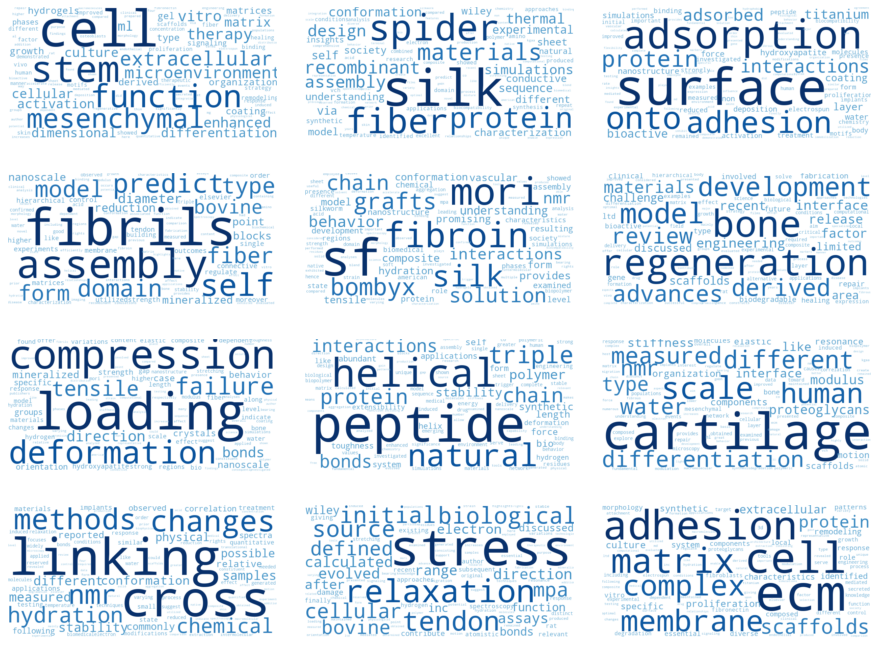

In [55]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()


## Visualization

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 105 samples in 0.000s...
[t-SNE] Computed neighbors for 105 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 105 / 105
[t-SNE] Mean sigma: 0.204140
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.380745
[t-SNE] KL divergence after 1000 iterations: 0.592205


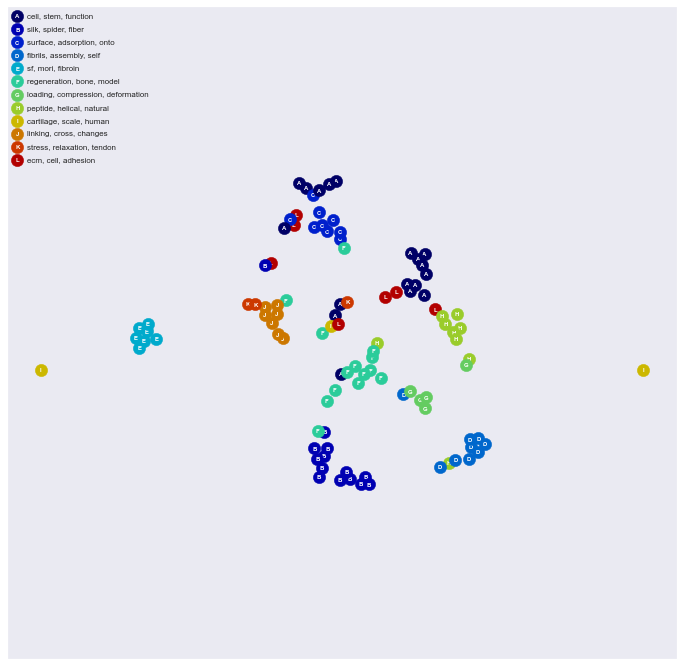

In [56]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model, tune perplexity value according to complexity of data
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=5)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

A General Strategy for Extrusion Bioprinting of Bio-Macromolecular Bioinks through Alginate-Templated Dual-Stage Crosslinking


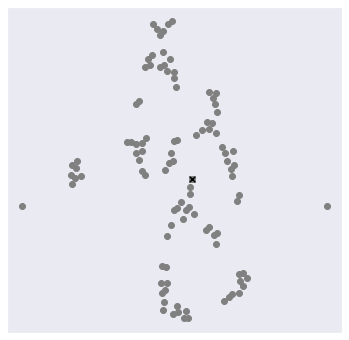

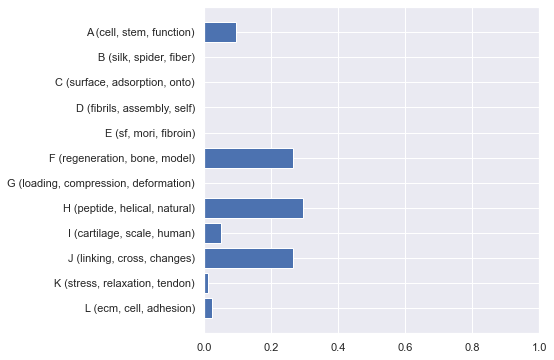

© 2018 WILEY-VCH Verlag GmbH & Co. KGaA, WeinheimThe recently developed 3D bioprinting technology has greatly improved the ability to generate biomimetic tissues that are structurally and functionally relevant to their human counterparts. The selection of proper biomaterials as the bioinks is a key step toward successful bioprinting. For example, viscosity of a bioink is an important rheological parameter to determine the flexibility in deposition of free-standing structures and the maintenance of architectural integrity following bioprinting. This requirement, however, has greatly limited the selection of bioinks, especially for those naturally derived due to their commonly low mechanical properties. Here the generalization of a mechanism for extrusion bioprinting of bio-macromolecular components, mainly focusing on collagen and its derivatives including gelatin and gelatin methacryloyl, is reported. Specifically, a templating strategy is adopted using a composite bioink containing bo

In [57]:
def on_select(i):
    p = papers[i]
    print(p.title)
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p.abstract)

options = sorted([((p.title or '').strip()[:50], i) for i, p in enumerate(papers)])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
widget